In [33]:
import sv_utils
import torch 
import numpy as np
import pylab as plt
from os.path import dirname, realpath

## Sequence Visualizer

El proposito de esta notebook es el poder graficar tanto la entrada como salida de la red DSNN que reconoce patrones en una secuencia de numeros aleatorios.

In [34]:
Sin_tmp = np.load('./sequences/seq_0.npy')
print(Sin_tmp.shape)
Sin = np.reshape(Sin_tmp, (Sin_tmp.shape[0]*Sin_tmp.shape[1], Sin_tmp.shape[2]))
Sin = np.transpose(Sin)
print(Sin.shape)

(34, 34, 3250)
(3250, 1156)


### Tren de spikes de entrada

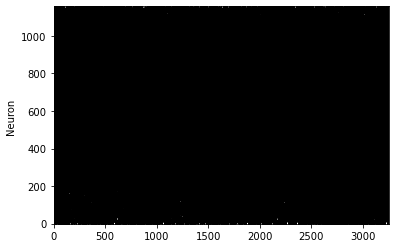

530426

In [35]:
sv_utils.plotLIF(U=None, S=Sin)
np.count_nonzero(Sin)

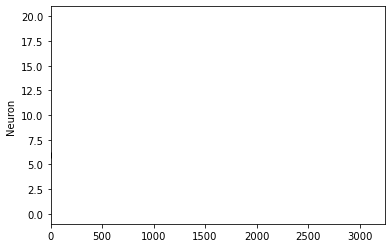

torch.Size([3250, 20])


1

In [36]:
Sin_out = torch.load('../SDNN-Maxi/results/Sin-out.pt')
sv_utils.plotLIF(U=None, S=Sin_out.data.numpy())
print(Sin_out.shape)
np.count_nonzero(Sin_out)

In [37]:
Sprobe = torch.load('../SDNN-Maxi/results/Sprobe.pt')
Uprobe = torch.load('../SDNN-Maxi/results/Uprobe.pt')
pat_times = np.load('./sequences/pat_i_0.npy')
print(Sprobe.shape)

(3250, 1)


### Potencial de membrana de salida

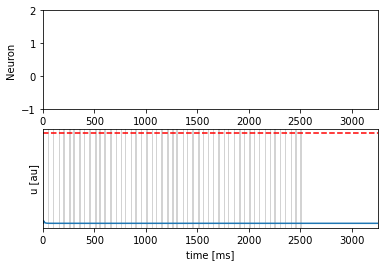

(<AxesSubplot:ylabel='Neuron '>,
 <AxesSubplot:xlabel='time [ms]', ylabel='u [au]'>)

In [38]:
sv_utils.plotLIF(U=Uprobe, S=Sprobe, pat_times=pat_times, th=25.)